# Project Plan
**Goal:** Building a predicitive model for Soybean Production yield and total production
* Soybeans production yield has a relatively constant trend through time. 
* The planting and harvesting seasons are almost same at each state it is produced. 
Thus, we can select only the growing season for agroclimatic variables and use states as a categorical

In [1]:
import os
import cdsapi

import numpy as np
import pandas as pd
import pandas_profiling
import geopandas
import netCDF4
import xarray as xarr # pandas based library for 
            # labeled data with N-D tensors at each dimension
import salem

import matplotlib.pyplot as plt
%matplotlib inline 
import cartopy
import cartopy.crs as ccrs
import seaborn as sns

# Preparing The Crop Production Data
Crop Data is obtained from: https://quickstats.nass.usda.gov/results/347988B6-8746-305D-9147-D1A31FE09FD2

For this study the yield of alfalfa hay, soy beans and corn grains will be modeled.

Here is the map that shows where these crops are produced
Source: https://www.nass.usda.gov/Charts_and_Maps/Crops_County/al-ha.php

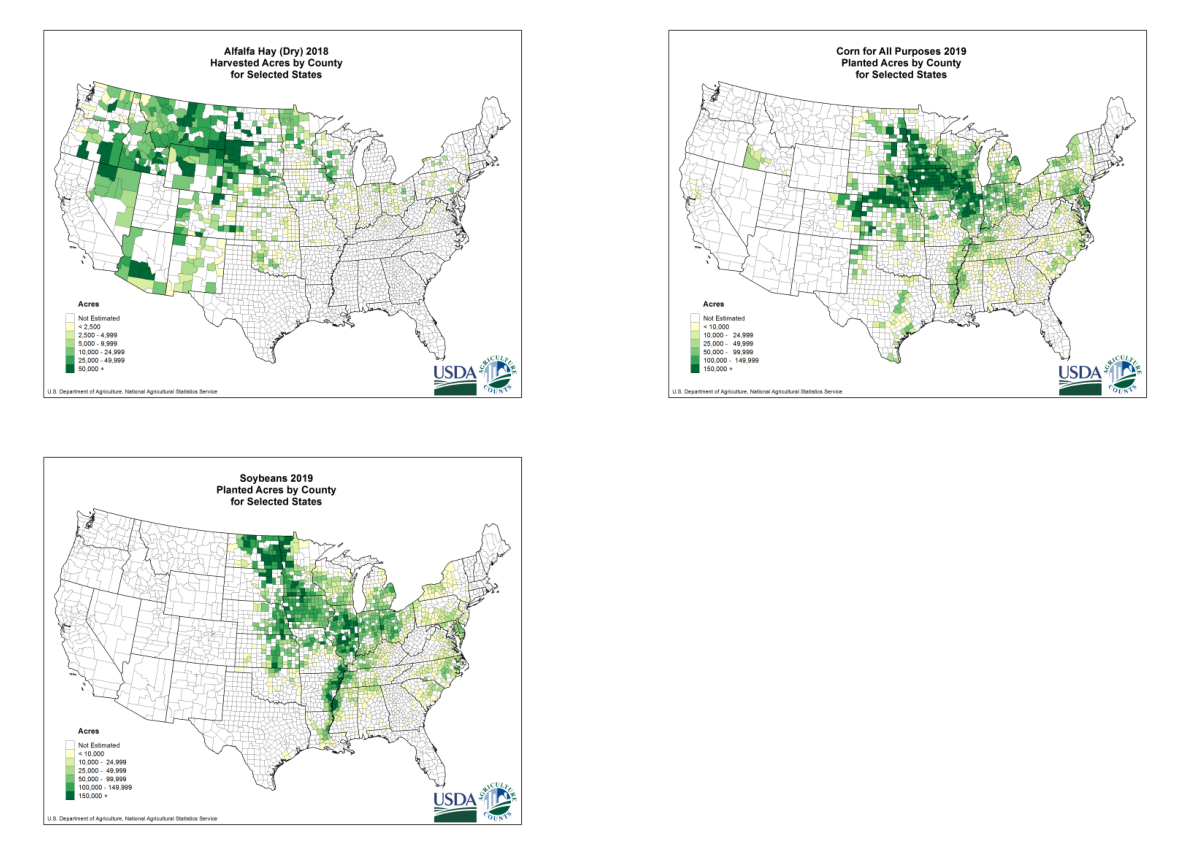

In [2]:
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

mpl.rc('figure', figsize = (18,12))
fig = plt.figure()
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

a = plt.imread("https://www.nass.usda.gov/Charts_and_Maps/graphics/AL-HA-RGBChor.png")
ax1.imshow(a)
c = plt.imread("https://www.nass.usda.gov/Charts_and_Maps/graphics/CR-PL-RGBChor.png")
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(c)
s = plt.imread("https://www.nass.usda.gov/Charts_and_Maps/graphics/SB-PL-RGBChor.png")
ax3 = fig.add_subplot(gs[1, 0])
ax3.imshow(s)
for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
plt.tight_layout()
plt.show()
plt.close()

mpl.rcParams.update(mpl.rcParamsDefault)

<div class="span5 alert alert-info">
Crop production data contain various fields. The most important fields for this work are the State, Commodity, and the yield (Value). However, we do not need all the eentries as some of them are irrelevant for our purpose or using them make it too complex for the scope of this work. Therefore, we will use most of the columns, even if we wouldn't need them eventually, to filter out those entries we want to get rid of.
</div>

In [3]:
#  Now Reading All the Crop Data that we are interested in to a dataframe
path = "Data/"
# Let's read and merge all the crops data into a single dataframe
# This way data wrangling steps will be less cumbersome
files = [path+"Alfala.csv", path+"Corn.csv", path+"Soybean.csv"]
df = (pd.read_csv(f) for f in files)
df_crop = pd.concat(df, ignore_index=True)
df_crop.head(3).T

,0,1,2
Program,SURVEY,SURVEY,SURVEY
Year,2019,2019,2019
Period,YEAR,YEAR,YEAR
Week Ending,NaN,NaN,NaN
Geo Level,STATE,STATE,STATE
State,IDAHO,IDAHO,MONTANA
State ANSI,16,16,30
Ag District,NaN,NaN,NaN
Ag District Code,NaN,NaN,NaN
County,NaN,NaN,NaN


In [4]:
df_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8522 entries, 0 to 8521
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Program           8522 non-null   object 
 1   Year              8522 non-null   int64  
 2   Period            8522 non-null   object 
 3   Week Ending       0 non-null      float64
 4   Geo Level         8522 non-null   object 
 5   State             8522 non-null   object 
 6   State ANSI        8522 non-null   int64  
 7   Ag District       0 non-null      float64
 8   Ag District Code  0 non-null      float64
 9   County            0 non-null      float64
 10  County ANSI       0 non-null      float64
 11  Zip Code          0 non-null      float64
 12  Region            0 non-null      float64
 13  watershed_code    8522 non-null   int64  
 14  Watershed         0 non-null      float64
 15  Commodity         8522 non-null   object 
 16  Data Item         8522 non-null   object 


We are not interested in most of these columns. The only relevant columns are these: `State`, `State ANSI` (may be helpful for a regression model), `Commodity`, `Data Item`(that is the column associated with the Value column along with State colums), `Domain`, `Value` (This is what we are trying to predict). However, we might need to check them first to decide which rows to include for our model. 

* **Value column is object type. We need to convert it to Float.**
* Also Let's drop all other nan values. None of the columns we are interested in has any nan values.


In [5]:
f = lambda x: x.replace(',', '')
df_crop['Value'] = df_crop['Value'].apply(f)
# Before converting to numeric let's see if there is non-numeric values and what they are
def IsNumeric(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
S = lambda s: isinstance(s, (int, float))
_isdigit = df_crop['Value'].apply(IsNumeric)
_r = df_crop[~_isdigit]['Value'].value_counts()
print(f'There are {_r[0]} entries with the value of "{_r.index[0]}"' )

There are 156 entries with the value of " (D)"


**According to the [Quick Stats Glossary](https://quickstats.nass.usda.gov/src/glossary.pdf) published by USDA for this dataset "D" corresponds to:** 

> **Withheld to avoid disclosing data for individual operations.**

Thus all we can do is dropping these rows.


In [6]:
df_crop['Value'] = pd.to_numeric(df_crop['Value'], errors='coerce')
df_crop['Value'].isnull().sum()

156

<div class="span5 alert alert-info">
Now Let's drop all nan values together. Let's first check the with null values in the dataframe
    </div>

In [7]:
# Missing Values
nan=pd.DataFrame(df_crop.isnull().sum().sort_values(ascending=False), columns = ['NULL values'])
nan.query('`NULL values` > 0').T

,County ANSI,Ag District Code,Watershed,Week Ending,Region,Zip Code,County,Ag District,CV (%),Value
NULL values,8522,8522,8522,8522,8522,8522,8522,8522,7561,156


In [8]:
#first get rid of the nan values in Value column only
df_crop.dropna(subset=['Value'], inplace=True)

# Now we can drop all the columns with nan values at once
df_crop.dropna(axis=1, inplace=True)

# Fixing the index
df_crop.reset_index(drop=True, inplace=True)
print(df_crop.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8366 entries, 0 to 8365
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Program          8366 non-null   object 
 1   Year             8366 non-null   int64  
 2   Period           8366 non-null   object 
 3   Geo Level        8366 non-null   object 
 4   State            8366 non-null   object 
 5   State ANSI       8366 non-null   int64  
 6   watershed_code   8366 non-null   int64  
 7   Commodity        8366 non-null   object 
 8   Data Item        8366 non-null   object 
 9   Domain           8366 non-null   object 
 10  Domain Category  8366 non-null   object 
 11  Value            8366 non-null   float64
dtypes: float64(1), int64(3), object(8)
memory usage: 784.4+ KB
None


**There are some constant values and some entries we are not interested in. Let's remove them from the df_crop**

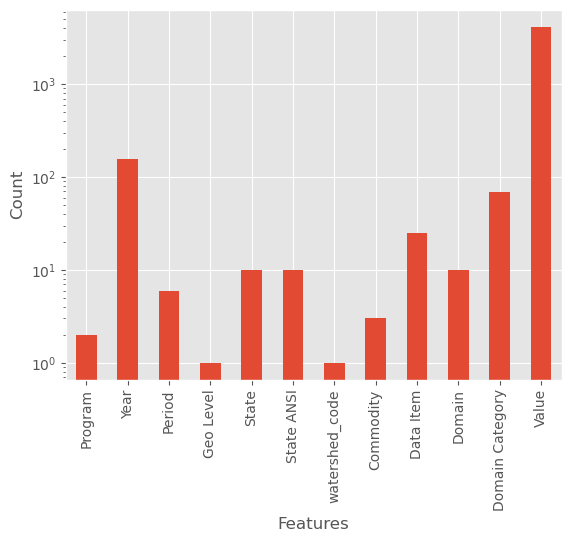

In [9]:
# First let's take a look at the number of unique 
# values in each column in a bar plot
plt.style.use('ggplot')
df_crop.nunique().plot(kind='bar', logy=True)
plt.xlabel('Features')
plt.ylabel('Count')
plt.show()
plt.close()
# Find those columns with constant values

**We need only Year entries for Period. Let's see what else is in there**

In [10]:
df_crop['Period'].value_counts()

YEAR                   6112
YEAR - AUG FORECAST     637
YEAR - OCT FORECAST     564
YEAR - SEP FORECAST     502
YEAR - NOV FORECAST     479
YEAR - JUN ACREAGE       72
Name: Period, dtype: int64

Looks like some values are just forecast entries not observations. We don't need any of those.

In [11]:
# dropping all rows with forecast entries given in Period column
mask_year = df_crop['Period'] == 'YEAR'
df_crop = df_crop[mask_year]
df_crop.reset_index(drop=True, inplace=True)
df_crop.nunique()

Program               2
Year                155
Period                1
Geo Level             1
State                10
State ANSI           10
watershed_code        1
Commodity             3
Data Item            25
Domain               10
Domain Category      69
Value              3937
dtype: int64

**Let's take a look at the Domain Catogories.**
* For this study some of the domains are irrelavant, like "ECONOMIC CLASS"
* Domain Catogories should be consistent among all "Data Item" values

<div class="span5 alert alert-info">
We have two sources of records which are given in the `Program` field. Let's check these resources.
    </div>

In [12]:
df_crop['Program'].value_counts()

SURVEY    4929
CENSUS    1183
Name: Program, dtype: int64

In [13]:
mask_DomCat = df_crop['Domain Category'] != 'NOT SPECIFIED'
print(df_crop[mask_DomCat].Commodity.value_counts())
print(df_crop[mask_DomCat].Program.value_counts())
df_crop[mask_DomCat]['Domain Category'].value_counts()

SOYBEANS    1119
Name: Commodity, dtype: int64
CENSUS    1119
Name: Program, dtype: int64


AREA HARVESTED: (250 TO 499 ACRES)       40
AREA HARVESTED: (500 TO 999 ACRES)       40
AREA HARVESTED: (100 TO 249 ACRES)       39
AREA HARVESTED: (1,000 OR MORE ACRES)    39
AREA HARVESTED: (50.0 TO 99.9 ACRES)     38
                                         ..
WATER SOURCE: (ON FARM SURFACE)           7
ECONOMIC CLASS: (1,000 TO 2,499 $)        7
NAICS CLASSIFICATION: (1113)              6
WATER SOURCE: (OFF FARM)                  6
NAICS CLASSIFICATION: (11191)             1
Name: Domain Category, Length: 68, dtype: int64

<div class="span5 alert alert-info">
There are 69 Domain Categories, but only Soybeans from CENSUS have Categories other than <code>NOT SPECIFIED</code>.
<b>Hence, for now I seperate all those Domain Categories to deal with them later since they require special handling.</b>

Note that these entries are from CENCUS records. Thus it is already more reasonable not to mix data from two different source <b>("Survey and Cencus")</b>
    </div>

In [14]:
# creating new dataframe for soybeans from CENSUS
df_soybean_census = df_crop[mask_DomCat]

# Crerating a new dataframe for Survey only crops
df_crop_srv = df_crop[~mask_DomCat]

# Let's see what commodities left in the df_crop_srv
df_crop_srv.Commodity.value_counts()

CORN        2685
HAY         1504
SOYBEANS     804
Name: Commodity, dtype: int64

In [15]:
df_crop_srv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993 entries, 0 to 6111
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Program          4993 non-null   object 
 1   Year             4993 non-null   int64  
 2   Period           4993 non-null   object 
 3   Geo Level        4993 non-null   object 
 4   State            4993 non-null   object 
 5   State ANSI       4993 non-null   int64  
 6   watershed_code   4993 non-null   int64  
 7   Commodity        4993 non-null   object 
 8   Data Item        4993 non-null   object 
 9   Domain           4993 non-null   object 
 10  Domain Category  4993 non-null   object 
 11  Value            4993 non-null   float64
dtypes: float64(1), int64(3), object(8)
memory usage: 507.1+ KB


<div class="span5 alert alert-info">
Still there are more columns than we need. Let's drop the ones we will not use. <b>We do not need constant value columns</b>
    </div>

In [16]:
# Getting rid of the columns with constant values
nunq = df_crop_srv.nunique()
dropped = []
for clm in df_crop_srv:
    if nunq.loc[clm] == 1:
        df_crop_srv = df_crop_srv.drop(clm, axis=1)
        dropped.append(clm)
print(df_crop_srv.nunique(),'\n\n')
print(f'dropped columns: {dropped}')

Program          2
Year           155
State           10
State ANSI      10
Commodity        3
Data Item       21
Value         2960
dtype: int64 


dropped columns: ['Period', 'Geo Level', 'watershed_code', 'Domain', 'Domain Category']


In [17]:
# Now fixing the index
df_crop_srv = df_crop_srv.reset_index(drop=True)
df_crop_srv.sample(3)

,Program,Year,State,State ANSI,Commodity,Data Item,Value
1514,SURVEY,2020,NEBRASKA,31,CORN,"CORN, GRAIN - PRODUCTION, MEASURED IN BU",1.776600e+09
1181,SURVEY,1959,WYOMING,56,HAY,"HAY, ALFALFA, NON-IRRIGATED - ACRES HARVESTED",1.194000e+05
1051,SURVEY,1967,WYOMING,56,HAY,"HAY, ALFALFA, NON-IRRIGATED - ACRES HARVESTED",9.370000e+04


# Preparing the Agroclimatic Geospatial Time Series Data
<table class="abstract-description abstract-table">
        <tbody><tr><th colspan="2">DATA DESCRIPTION</th>
        
</tr><tr><th>Data type</th><td>Gridded</td></tr>
<tr><th>Projection</th><td>Regular latitude-longitude grid</td></tr>
<tr><th>Horizontal coverage</th><td>Global</td></tr>
<tr><th>Horizontal resolution</th><td>0.5° x 0.5°</td></tr>
<tr><th>Vertical coverage</th><td>Surface</td></tr>
<tr><th>Vertical resolution</th><td>Single level</td></tr>
<tr><th>Temporal coverage</th><td>1951 to 2099</td></tr>
<tr><th>Temporal resolution</th><td>Variable dependent: 10-day, seasonal or annual</td></tr>
<tr><th>File format</th><td>NetCDF-4</td></tr>
<tr><th>Conventions</th><td>Climate and Forecast (CF) Metadata Convention v1.7</td></tr>
<tr><th>Update frequency</th><td>No updates expected</td></tr>
</tbody></table>


 #### Download the data using CDSAPI

In [18]:
# # This cell needs to be run only once, when the agroclimatic indicators are downloaded from the source

# c = cdsapi.Client()

# c.retrieve(
#     'sis-agroclimatic-indicators',
#     {
#         'origin': 'era_interim_reanalysis',
#         'variable': [
#             'biologically_effective_degree_days', 'frost_days', 'heavy_precipitation_days',
#             'ice_days', 'maximum_of_daily_maximum_temperature', 'maximum_of_daily_minimum_temperature',
#             'mean_of_daily_maximum_temperature', 'mean_of_daily_mean_temperature', 'mean_of_daily_minimum_temperature',
#             'mean_of_diurnal_temperature_range', 'minimum_of_daily_maximum_temperature', 'minimum_of_daily_minimum_temperature',
#             'precipitation_sum', 'simple_daily_intensity_index', 'summer_days',
#             'tropical_nights', 'very_heavy_precipitation_days', 'wet_days',
#         ],
#         'experiment': 'historical',
#         'temporal_aggregation': '10_day',
#         'period': '198101_201012',
#         'format': 'zip',
#     },
#     'download.zip')

#### Reading data as an Xarray dataset
The agroclimatic data is a gridded time series data. It comes as a Netcdf file, which contains the latitude, longtitude and altitude coordinates and time dimension as well as 26 agroclimatic indicators. Although pandas data frame can be used to import this data, it would be too cumbersome to do so due to unusual structure of the data. Xarray library on the other hand is built exactly for handling this type of dataset.

In [19]:
# Read the data Path where they are stored on the Computer
#data_dir = input('Path to the data\n')
paths = []
for folder in ['dekadal', 'seasonal', 'annual']:
    paths += [os.path.join('C:\\'
                'Users',
                'kurt_',
                'Data',
                'agroclimate',
                 folder,'')]
dekadal_dir, seasonal_dir, annual_dir = paths

#### Importing the Indicators
<div class="span5 alert alert-info">
Each agroclimatic indicator is stored in the disk as a single netcdf file. <b>All the files will be merged into a single xarray dataset which will be divided into chunks and parallelization with dask will be enabled to speed up the operations</b>
</div>

In [24]:
# Import data as xarray dataset from the directory
def read_nc_files(data_dir, chunk, dask=False):
    dask = True
    if dask:
        # Import with dask
        dt = xarr.open_mfdataset(data_dir+'*hist*.nc', parallel=True, 
                                  combine='by_coords', 
                                 chunks= chunk, # first spatial subsetting operations will be made.
                                 engine='netcdf4') # if available, h5netcdf engine is fatser than netcdf4
    else:
        # Import without dask for debugging
        dt = xarr.open_mfdataset(data_dir+'*hist*.nc', parallel=True, 
                              combine='by_coords', engine='netcdf4')
    return dt
clim_dek = read_nc_files(dekadal_dir, chunk={'time':20}, dask=True) # The size on the disk is 2.4gb
clim_seas = read_nc_files(seasonal_dir, chunk=None)
clim_ann = read_nc_files(annual_dir, chunk=None)

#### Selecting U.S.
Since the final model will only apply to some continental U.S. states, there is no need to work on global data. Removing the rest of the world's data significantly reduces memory demand.

In [25]:
# selecting U.S. only
clim_dek = clim_dek.sel(lon=slice(-140, -50) ,lat=slice(15,60))
clim_seas = clim_seas.sel(lon=slice(-140, -50) ,lat=slice(15,60))
clim_ann = clim_ann.sel(lon=slice(-140, -50) ,lat=slice(15,60))

# Write them to disk and re-read them without chunks
ds_dict = {'dekadal':clim_dek, 'seasonal': clim_seas,
           'annual': clim_ann}
for ds_key in ds_dict:
    # write the data into folders with paths dek_dir, seas_dir or ann_dir 
    ds_dict[ds_key].to_netcdf(f'{eval(ds_key+"_dir")}{ds_key}.nc')

In [85]:
# Reading the us data from the disk
clim_dek = xarr.open_dataset(dekadal_dir+"dekadal.nc", chunks={'time':135}) # this is now only ~300 mb. No need chunks
clim_seas = xarr.open_dataset(seasonal_dir+"seasonal.nc")
clim_ann = xarr.open_dataset(annual_dir+"annual.nc")

### Exploring the agroclimatic indicators datasets

In [86]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [87]:
def plot_2d(var, time):
    # ploting the first time step to check the selected area
    ax = clim_dek[var].isel(time=time).plot(figsize=(10,5))
    plt.show()
    return ax
interact(plot_2d, var=[i for i in clim_dek if i!= 'time_bounds'], time=(1,1080,36))

interactive(children=(Dropdown(description='var', options=('BEDD', 'DTR', 'FD', 'ID', 'R10mm', 'R20mm', 'RR', …

<function __main__.plot_2d(var, time)>

In [88]:
def explore_ds(dt):
    for var in dt:
        print(f'{var}: {dt[var].attrs}')
    # Let's select the first time step and plot the 2m-air temperature

    # Let's check the dimensions
    for dim in dt.dims:
        dimsize = dt.dims[dim]
        print(f'\nData has {dimsize} {dim} ')
        if dim == 'latitude':
            print(f' latitudes: from {float(dt[dim].min())} degree South',
         f'to {float(dt[dim].max())} degree North')
        if dim == 'longitude':
            print(f' Longitudes: from {float(dt[dim].max())} degree East',
         f'to {float(dt[dim].min())} degree West')
        if dim == 'time':
            print(f'time: from {pd.to_datetime(dt["time"].min().values)} to\
                  {pd.to_datetime(dt["time"].max().values)} ')

#### Dekadal variables

In [89]:
explore_ds(clim_dek)

time_bounds: {}
BEDD: {'units': 'degrees_C', 'long_name': 'Biologically Effective Degree Days', 'cell_methods': 'time: sum'}
DTR: {'units': '', 'long_name': 'Mean of diurnal temperature range', 'cell_methods': 'time: mean'}
FD: {'units': 'day', 'long_name': 'Frost days (minimum temperature < 0 degrees_C)', 'cell_methods': 'time: sum'}
ID: {'units': 'day', 'long_name': 'Ice days (maximum temperature < 0 degrees_C)', 'cell_methods': 'time: sum'}
R10mm: {'units': 'day', 'long_name': 'Heavy precipitation days (precipitation >= 10 mm)', 'cell_methods': 'time: sum'}
R20mm: {'units': 'day', 'long_name': 'Very heavy precipitation days (precipitation >= 20 mm)', 'cell_methods': 'time: sum'}
RR: {'units': 'mm', 'long_name': 'Precipitation sum', 'cell_methods': 'time: sum'}
RR1: {'units': 'day', 'long_name': 'Wet days (precipitation >= 1 mm)', 'cell_methods': 'time: sum'}
SDII: {'units': 'mm', 'long_name': 'Simple daily intensity index for wet days (mm/wet day)', 'cell_methods': 'time: mean'}
SU:

Dekadal dataset have 2 spatial, one time coordinates and 15 variables. Now let's see what each of these variables are.

#### Seasonal variables

In [90]:
explore_ds(clim_seas)

time_bounds: {}
CDD: {'units': 'day', 'long_name': 'Maximum number of consecutive dry days (precipitation < 1 mm)', 'cell_methods': 'time: maximum'}
CFD: {'units': 'day', 'long_name': 'Maximum number of consecutive frost days (minimum temperature < 0 degrees_C)', 'cell_methods': 'time: maximum'}
CSDI: {'units': 'day', 'long_name': 'Cold-spell duration index', 'cell_methods': 'time: sum'}
CSU: {'units': 'day', 'long_name': 'Maximum number of consecutive summer days(temperature > 25 degrees_C)', 'cell_methods': 'time: maximum'}
CWD: {'units': 'day', 'long_name': 'Maximum number of consecutive wet days (precipitation >= 1 mm)', 'cell_methods': 'time: maximum'}
WSDI: {'units': 'day', 'long_name': 'Warm-spell duration index', 'cell_methods': 'time: sum'}
WW: {'units': 'day', 'long_name': 'Warm and wet days', 'cell_methods': 'time: sum'}

Data has 2 bounds 

Data has 90 lat 

Data has 180 lon 

Data has 119 time 
time: from 1981-04-16 00:00:00 to                  2010-10-16 00:00:00 


Seasonal dataset have 2 spatial, one time coordinates and 7 variables. Now let's see what each of these variables are.

#### Annaul variable

In [91]:
explore_ds(clim_ann)

time_bounds: {}
GSL: {'units': 'day', 'long_name': 'Growing season length', 'cell_methods': 'time: sum'}

Data has 2 bounds 

Data has 90 lat 

Data has 180 lon 

Data has 30 time 
time: from 1981-07-01 00:00:00 to                  2010-07-01 00:00:00 


There is only a single annual variable.

#### Droping variables Not Needed
<div class="span5 alert alert-info">
Some of these variables are related to variation in the climate. However, in this study trend in climate variables will be removed and climate change is not studied. Hence some of these variables will be removed.
    </div>

In [92]:
# create a list of variables to keep
vars_to_keep = ['BEDD', 'CSDI', 'FD', 'GSL', 'R10mm', 
        'ID', 'CDD','CFD', 'CSU', 'CWD', 'TX',
       'TG', 'DTR', 'RR', 'SU', 'TR', 'R20mm',
       'WW', 'WSDI', 'RR1']
# Drop all but these variables in the vars_to_keep
def DropVars(ds):
    for var in ds:
        if var not in vars_to_keep:
            ds = ds.drop_vars(var)
    return ds
    
clim_dek = DropVars(clim_dek)

## Merging All Climate Datasets 
**(Dekadal, Seasonal, Annual)**

<div class="span5 alert alert-warning">
<ul> <li>Some variables are aggregated as sum of all the occurence  during default time interval (10 days), while some are averaged.</li> 
    <li>The aggregation method is recorded in "cell_methods" attribute of the variable.</li> 
    <li>Using cell_methods for each variable annual aggregations will be calculated.</li>
    <li>All three datasets will be merged into a single one.</li>
    <li>Then, All the climate parameters will be spatially averaged through the state level.</li></ul>
</div>

#### Resampling Dekadal Variables
**The planting season roughly start on May and the harvesting ends before December at each state. The only climate variables relavant is in this range in each year. Therefore, let's select only this months and then yearly resample all the variables**

Let's define a function to resample the datasets. Resample method for each variable should be choosen from it's cell_method, which tells how the variable is agregated through time. 

In [93]:
def resample_with_cell_method(ds, frq='AS'):
    """Resample the input dataset to a frequency given as frq as input
    with resampling method unique for each variable, in accordance with 
    their cell method, how they originally aggregated """

    # Resampling annualy
    ds_resampled = ds.resample(time=frq, keep_attrs=True)
    
    # creating a list to merge indpendently resampled variables
    dt_arrays_to_merge = []

    # iterate over each variable
    for var in ds:
        # skip time_bounds variable
        if var == "time_bounds":
            continue
        # resampling method based on each variable's cell_method
        if "mean" in ds[var].cell_methods:
            vars()[var] = ds_resampled.mean(keep_attrs=True)[var]
        elif "maximum" in ds[var].cell_methods:
            vars()[var] = ds_resampled.max(keep_attrs=True)[var]
        elif "minimum" in ds[var].cell_methods:
            vars()[var] = ds_resampled.min(keep_attrs=True)[var]
        elif "sum" in ds[var].cell_methods:
            vars()[var] = ds_resampled.sum(keep_attrs=True)[var]
        # appending resampled variable to the list
        dt_arrays_to_merge.append(eval(var))

    # Merge all variables back to a dataset
    return xarr.merge(dt_arrays_to_merge)

In [94]:
# Selecting the relavant months in each year
sel_dates = clim_dek.time.values[(clim_dek.time.dt.month > 4) & (clim_dek.time.dt.month < 12)]
clim_dek_subset = clim_dek.sel(time=sel_dates)

In [95]:
clim_dek_to_ann = resample_with_cell_method(clim_dek_subset)
clim_dek_to_ann.dims

Frozen(SortedKeysDict({'time': 30, 'lat': 90, 'lon': 180}))

The dekadal data is now downsampled to yearly data.

#### Resampling Seasonal Variables
We need the data for the months covering May - November. Either Spring, Summer and Fall should be selected to cover all the growing season or we could just select summer and Fall, since the values agregated through March and April should have no affect on the soybean production, and yet they are included in the spring data. Besides, none of the southern states, where the planting season starts earlier, included in the soybean yield data. For the states included in the data, the most active planting season usualy starts near the end of the May <b style="color:red">*</b>.

Thus, I will only select summer and fall seasons for the afferomentioned reasons 

<b style="color:red">\*Source:</b> https://swat.tamu.edu/media/90113/crops-typicalplanting-harvestingdates-by-states.pdf

In [96]:
# Selecting the summer and fall seasons in each year
sel_dates = clim_seas.time.values[clim_seas.time.dt.month >= 7]
clim_seas_subset = clim_seas.sel(time=sel_dates)

In [97]:
clim_seas_to_ann = resample_with_cell_method(clim_seas_subset)
clim_seas_to_ann.dims

Frozen(SortedKeysDict({'time': 30, 'lat': 90, 'lon': 180}))

#### Merging all three datasets
Now that the dekadal and seasonal datasets are resampled annually, they can be merged into a single dataset holding all the agro-climatic indicators.
Note that clim annual index is a bit different. Each years sample recorded on july, while they are recorded on the first month in the other datasets. Let's first fix it. Then merge all the datasets.

In [98]:
clim_ann.time.values[:5]

array(['1981-07-01T00:00:00.000000000', '1982-07-01T00:00:00.000000000',
       '1983-07-01T00:00:00.000000000', '1984-07-01T00:00:00.000000000',
       '1985-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [99]:
# fix the time dimension in clim_ann to match the others
clim_ann['time'] = clim_seas_to_ann['time']
clim_ann.time.values[:5]

array(['1981-01-01T00:00:00.000000000', '1982-01-01T00:00:00.000000000',
       '1983-01-01T00:00:00.000000000', '1984-01-01T00:00:00.000000000',
       '1985-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

This has resulted to partition the data to more chunks, but it doesn't matter as in the next part the combined dataset will be saved to disk, then reread with chunks on spatial dimensions, as the time dim has length of only 30 now.

In [ ]:
# Combine all the data to agro_clim dataset
agro_clim = xarr.merge([clim_dek_to_ann, clim_seas_to_ann, clim_ann])
# Let's save agro_clim to disk. This will save time when repeating the work
agro_clim.to_netcdf('C:\\Users\\kurt_\\Data\\agro_clim.nc')

Because some grids' are on water surface they are nan. This causes the warning `invalid value encountered` in divide. Though, it is possible to avoid it, it has no impact on the region we are interested in. 

In [33]:
del agro_clim

In [34]:
agro_clim = xarr.open_dataset('C:\\Users\\kurt_\\Data\\agro_clim_test1.nc')

In [58]:
def spatial_mean(ds):
    """lat-lon mean of the entire dataset
    accounting for the actual grid areas"""
    weight = np.cos(np.deg2rad(ds.lat))
    cos_lat_weighted_mean = ds.weighted(weight).mean(("lon", "lat"))

    return cos_lat_weighted_mean


def anomaly(da):
    """calculate anomaly"""

    clim = da.mean(dim='time')
    anom = da - clim

    return anom

def covmat(a,b):
    """covmat(a,b): calculate covariance between vector a and each grid point of matrix b
     returns a matrix with dimensions of b"""

    b1 = b.values
    s1 = np.shape(b1)
    a1 = a.values
    b1 = b1.reshape(s1[0],s1[1]*s1[2])

    a1 = a1 - np.average(a1);
    b1 = b1 - np.average(b1,axis=0)

    c1 = np.matrix(a)*np.matrix(b1)
    c1 = c1.reshape(s1[1],s1[2])/s1[0]
    c1 = xarr.DataArray(c1,dims=['lat','lon'],coords={'lat': b.lat, 'lon': b.lon})

    return c1


def detrend_2d(da):
    """linear detrend of 2D data set (lat x lon x time)
    returns anomaly"""

    da1 = anomaly(da)

    t1 = xarr.DataArray(np.arange(len(da1.time)),dims='time',coords={'time': da1.time})
    slope = covmat(t1,da1)/np.std(t1)**2

    da1 -= slope*t1 # remove linear trend
    da2 = anomaly(da1)

    return da2

In [38]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [39]:
def plot_spatial_mean(var='TG',time=1, detrend=True, spatial_mean = True):
    """Plot the spatial mean of anomalies of variables after detrending them"""
    fig, ax = plt.subplots(figsize=(8,5))
    if detrend == True:
        if spatial_mean == True:
            gavg(detrend_2d(agro_clim[var])).plot(marker='.', ax=ax)
            plt.title(agro_clim[var].long_name)
        elif spatial_mean == False:
            detrend_2d(agro_clim[var]).isel(time=time).plot(ax=ax)
            plt.title(agro_clim[var].long_name)
        else: 
            raise TypeError('spatial_mean should be "True" or "False"')
    elif detrend == False:
        if spatial_mean == True:
            gavg(agro_clim[var]).plot(marker='.', ax=ax)
            plt.title(agro_clim[var].long_name)
        elif spatial_mean == False:
            agro_clim[var].isel(time=time).plot(ax=ax)
        else: 
            raise TypeError('spatial_mean should be "True" or "False"')
    else:
        TypeError('detrend should be "True" or "False"')
    return fig, ax

In [40]:
variables = [i for i in agro_clim.data_vars if i !='time_bounds'] 
interact(plot_spatial_mean, var=variables, time=(0,29,1))
plt.show()

interactive(children=(Dropdown(description='var', index=9, options=('BEDD', 'DTR', 'FD', 'ID', 'R10mm', 'R20mm…

### Detrending Agro-Climatic Indicators (Features)
<div class="span5 alert alert-info">
The priority of this project is to investigate how crop yield is affected by weather conditions. Therefore interannual variability in yield is more important for this work than decadal variability where the latter is related not only Climate but also development in agricultural technologies and human beheviours.
    <p>Therofore, I will first detrend the predictors (agro-climatic indicators) and later the response variable (yield).</p>
    </div>

In [73]:
# applying detrend_2d function on all the variables in agro_clim dataset
agro_clim = agro_clim.map(detrend_2d, keep_attrs=True)

## Getting Climate For Product Zone
* Importing US-Census geospatial data for the state boundaries using __Geopandas package__
* Embedding state coordinates to Xarray climate dataset for state-wise operations. 
* Masking climate dataset only to keep the relavant states using **Salem package**

In [74]:
# Read the shape file for US States using Geopandas package
path_geo = 'C:\\Users\\kurt_\\Data\\usstates\\'
geo_usa = geopandas.read_file(path_geo)
print(type(geo_usa))
print('The coordinate Reference System Info:')
print(geo_usa.crs)
geo_usa.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
The coordinate Reference System Info:
epsg:4269


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


<div class="span5 alert alert-info">
Now the fun part:<br> We have coordinates of US state boundaries in the geo_usa data, let's plot the mainland US on a map based on these coordinates to see if everyhting is alright.
    </div>

Double Click To Zoom In


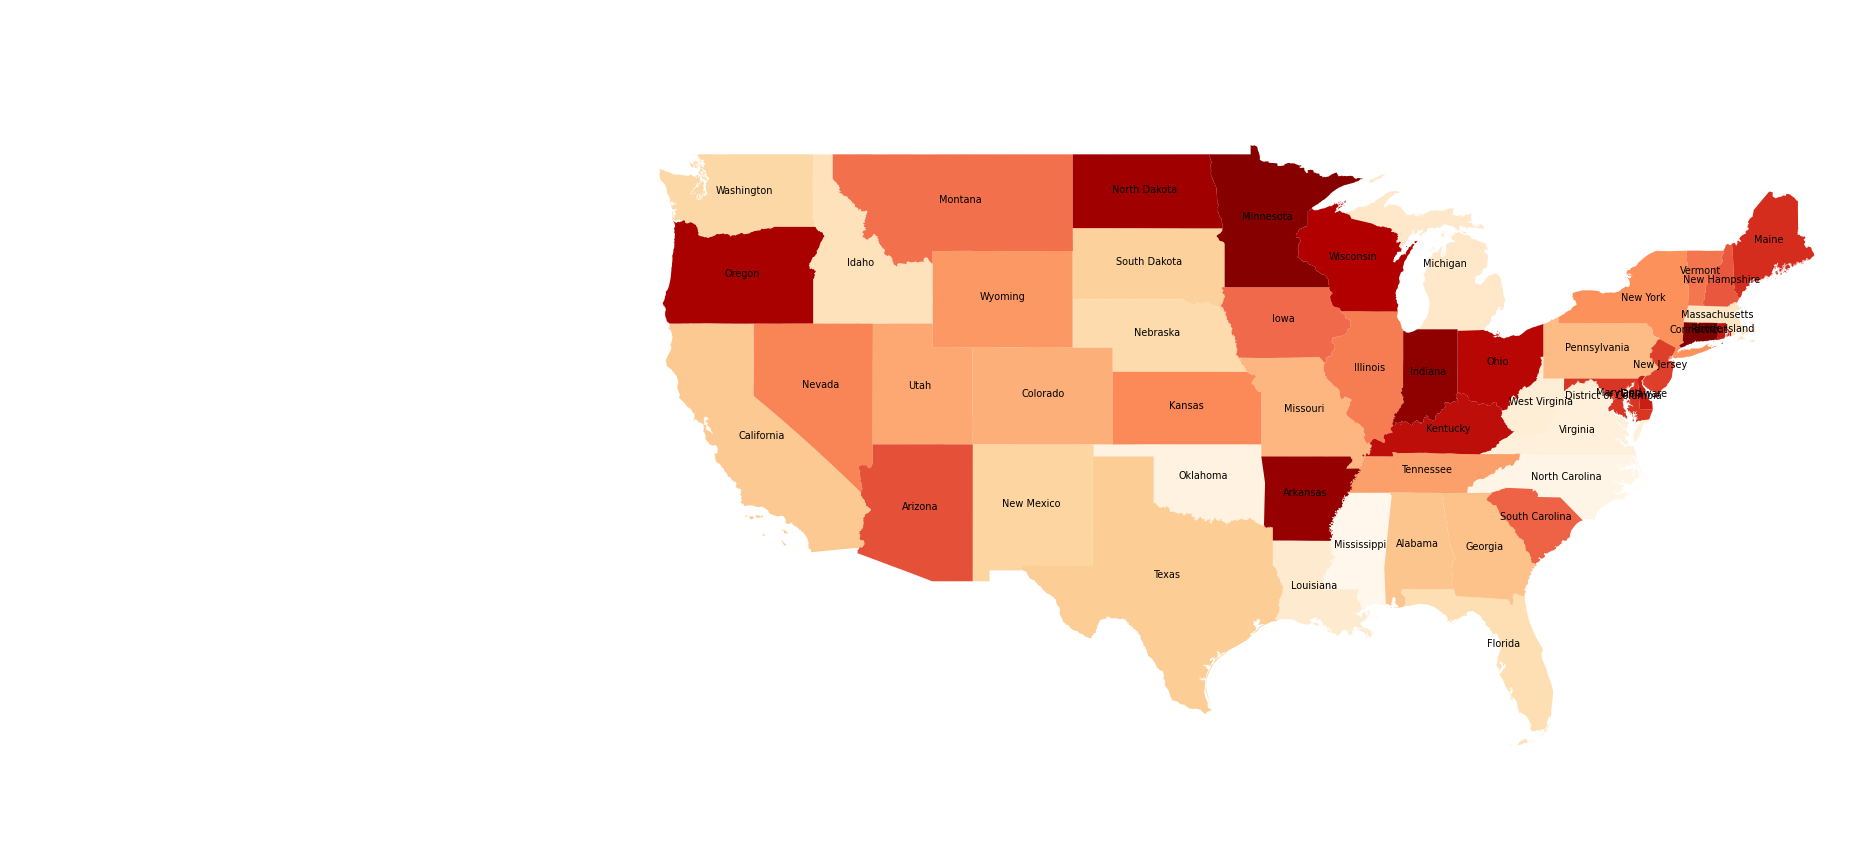

In [75]:
# Let's see the state boundaries on a map to see
# if there is an error

#Double click to zoom in
red = '\033[31;2;7m'
reset = '\033[0m'
print(red+"Double Click To Zoom In"+reset)

# Getting rid of oversees territories from the map
geo_usa = geo_usa[geo_usa.STATEFP.apply(lambda x: int(x)) < 60]
#Let's remove the Alaska too
geo_usa = geo_usa[geo_usa.NAME != 'Alaska']
fig,ax = plt.subplots(figsize=(16, 12))
geo_usa.plot(ax=ax, cmap='OrRd')
ax.set_xlim(-127,-65)
ax.set_ylim(22,55)
ax.set_yticks([])
ax.set_xticks([])
ax.axis("off")
geo_usa.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7),axis=1);
# plt.tight_layout()
plt.show()
plt.close()

#### Calculating State Means
<div class="span5 alert alert-info">
    <ul><li> Define a function to calculate state-wise spatial means for selected crops.</li>
    This will reduce the space-time data to a simple time-series for each state.
    <li>Then let's plot 2-d temperature variable of the states on a random day to make sure that everything is fine.</li>
</div>

SOYBEANS states: ['Illinois', 'Indiana', 'Iowa', 'North Dakota']


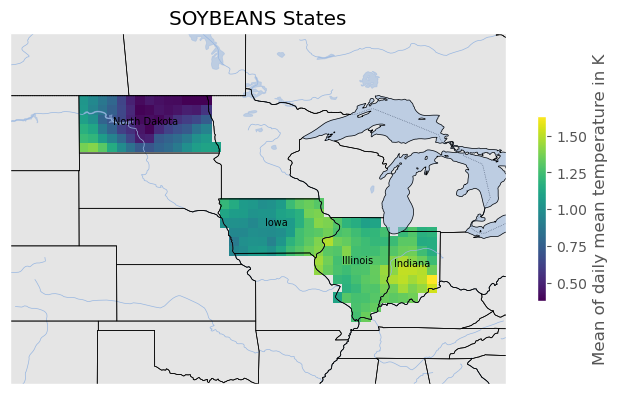

In [94]:
def sel_states(dt, crop, var=None, states='all', _plot=False):
    """Calculate state climate and Plot the region of interest from 
    the list of 'state' list. 
    var: which variable to plot. kywrd:
            Default = None: Do not plot any variables. if _plot=True a variable name has to be given intead
    state: which state to select. Default is 'all': all the states in df_crop 
            'crop': only the states for the selected crop
            state_name: Manually select states. State names should be a list of strings """
    # Getting State names
    if states not in ['all', 'crop']: # user selected states
        crop_states = [states.title()]  # just convert to upper case
    elif states == 'all':
        crop_states = list(df_crop_srv.State.unique())
        crop_states = [x.title() for x in crop_states]
    elif states == 'crop':
        crop_states = list(df_crop_srv[df_crop_srv['Commodity'] == crop]
                           .State.unique())
        crop_states = [x.title() for x in crop_states]
    print(f'{crop} states: {crop_states}')
    # Reading state shape files from census data using Salem
    us_states = salem.read_shapefile(path_geo+'cb_2018_us_state_500k.shp')
    state_coord = us_states[(us_states.NAME.isin(crop_states))]

    # Extracting only the region of interest from climate data
    state_clim = dt.salem.subset(shape=state_coord, 
                                 margin=5).salem.roi(shape=state_coord)
    
    # plotting the region of interest
    if _plot == True:
        plt.style.use('seaborn-colorblind')

        # Creating Figures
        fig = plt.figure(figsize=(8,6))

        # plotting on a map using cartopy
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
        ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
        ax.add_feature(cartopy.feature.RIVERS)
        ax.add_feature(cartopy.feature.STATES)

        # State names on the map
        state_coord.apply(lambda x: ax.annotate(text=x.NAME, 
                                                xy=x.geometry.centroid.coords[0], 
                                                ha='center', fontsize=7),axis=1);

        # Let's plot the variable at a random time
        randm_day = state_clim[var].isel( time=
                                         np.random.randint(len(state_clim.time)))

        # randm_day.salem.roi(shape=state_coord).plot(ax=ax)
    #     randm_day = randm_day.salem.roi(shape=state_coord)
        plt.pcolormesh(randm_day.lon, randm_day.lat, randm_day)

        cb = plt.colorbar(shrink=0.4) # use shrink to make colorbar smaller
        cb.set_label(f"{dt[var].long_name} in {dt[var].units}")

        plt.title(f'{crop} States')
    return state_clim
# let's see the sel_states function to get and plot the states where soybeans are grown
state_clim = sel_states(agro_clim,var='TG',crop='SOYBEANS', states='crop', _plot=True)
# plt.show()

#### Converting Xarray datasets to DataFrames
* Using `sel_states` function those states where soybeans are grown will be selected individually
* `spatial_mean` function will be used to take the proper spatial mean of each state along lat-lon dims.
    (This will produce a simple time series data for each state.)
* All the datasets will be converted to a dataframe

In [114]:
soy_states = list(df_crop_srv[df_crop_srv['Commodity'] == "SOYBEANS"]
                       .State.unique())

state_clim_list = []
for state in soy_states:
    state_clim = sel_states(agro_clim,
                            crop='SOYBEANS', states=state)
    
    # Calculate correct spatial mean for the state
    state_clim = spatial_mean(state_clim) # only dimension is time now
    
    # convert the state_clim to a dataframe
    state_clim = state_clim.to_dataframe()
    
    # add state name as a new column    
    # fill the State column with ones
    state_clim['State'] = np.ones(len(state_clim))
    # replace the ones with the state name
    state_clim['State'].replace(1, state, inplace=True)
    
    # collect state-mean datasets in a list to unpack later
    state_clim_list.append(state_clim)
    
# let's name each data set in the state_clim_list by their corresponding state name abbrevition
il_agro_clim, in_agro_clim, ia_agro_clim, nd_agro_clim =  state_clim_list
pd.concat(state_clim_list, axis=0)

SOYBEANS states: ['Illinois']
SOYBEANS states: ['Indiana']
SOYBEANS states: ['Iowa']
SOYBEANS states: ['North Dakota']


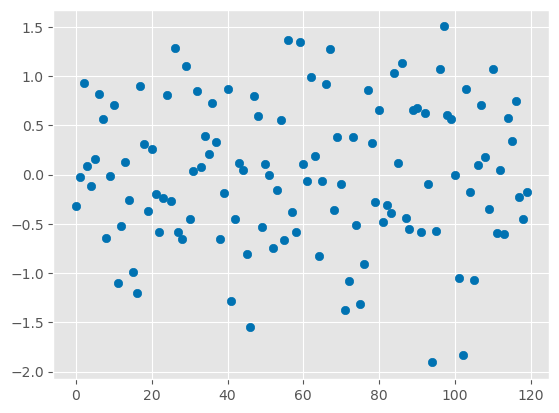

In [130]:
y= pd.concat(state_clim_list, axis=0)
x=np.arange(4*len(state_clim))
plt.scatter(x , y['TG'])

In [138]:
def plot_var(var):
    fig, ax = plt.subplots()
    for df in state_clim_list:
        df[var].plot(ax=ax)
        plt.title(agro_clim[var].long_name)
interact(plot_var, var=df.columns.values)
plt.show()

interactive(children=(Dropdown(description='var', options=('BEDD', 'DTR', 'FD', 'ID', 'R10mm', 'R20mm', 'RR', …

In [115]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 2, test_size=5)
X = il_agro_clim
for train_index, test_index in tss.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
X_test

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] TEST: [25 26 27 28 29]


,BEDD,DTR,FD,ID,R10mm,R20mm,RR,RR1,SU,TG,...,TX,CDD,CFD,CSDI,CSU,CWD,WSDI,WW,GSL,State
time,,,,,,,,,,,,,,,,,,,,,
2006-01-01,-38.766753,-0.201908,3.644416,-0.506473,0.614344,0.218751,-12.314324,0.632486,-8.405391,-0.262830,...,-0.290620,-0.185291,-0.658530,-0.372849,8.537015,-1.750376,1.304122,-0.738606,1.113459,ILLINOIS
2007-01-01,260.771406,0.590047,0.270337,-0.129726,-2.763311,-2.246560,-135.073846,-10.681667,24.962308,1.282371,...,1.573450,0.714389,1.109007,0.420086,11.547244,0.205235,2.948908,1.421318,-0.327226,ILLINOIS
2008-01-01,-81.851294,-0.119288,3.477145,0.216890,1.989265,0.282187,93.904793,1.245628,-2.044866,-0.577138,...,-0.633532,-4.061959,3.461940,-0.358338,6.934198,-1.130638,-0.976911,-0.240293,-16.718806,ILLINOIS
2009-01-01,-192.438905,-0.798707,-6.038298,-0.465779,4.636642,3.035583,154.283591,7.490485,-16.693249,-0.650130,...,-1.104045,-3.043205,-3.774109,-0.351082,-21.433412,0.144921,-0.935753,-0.290555,8.943046,ILLINOIS
2010-01-01,211.723971,0.492691,-0.225004,-0.420759,3.790468,0.444734,66.360450,9.063169,12.057900,1.104355,...,1.374914,2.618309,0.175366,-0.343826,26.716696,0.952991,0.293503,3.658308,7.253460,ILLINOIS


# Feature Engineering
The main problem in this data set is that there are only 30 observations, and as of this far, 20 agro-climatic indicators likely with high colinearity. To deal with this problem the following steps will be applied in this part
* Using simple techniques and domain knowledge only some of the most important columns will be selected as predictor variables. 
* Each of the four states' data will be stacked on top of each other.<br>
    **The advantages of this method:**
    1. Sample size will increase to 120. <br>
    2. We can split the data to train and test and still do cross validation with the train data
    **The disadvantages of this method:**
     1. Since the each states' climate data is annually sampled, spatially averaged, detrended and anamolous, they are similar to each other. Thus stacking them on top of each other is similar, to an extend, to repeating the 30 year-observation 4 times in the same data. The difference between the states could be from noise (impossible to model per se), difference in the affect of the climate variables on soybeans yield in each state. The former can be implemented in a model by one-hot encoding the states. 
     2. One-hot encoding will create 3 more features. Since the climate variables are similar in each state as explained above modeling the difference is difficult and normally requires large sample size.
     3. Due to time series nature of the data train-test splitting and cross validation becomes more complicated after stacking states data. 
     Overall, the benefits outwiegh the downsides
  

### Modelling
* 20% of each state data will be set aside for testing. i.e. one set of training data for each state
* All the state dataframes will be merged into a single dataframe with state_nam as a feature.
* 
    
<b style="color:red">High dimensionality problem:</b> <br>
We have 20 features 30 samples (each year) This is a problem because machine learning algorithms assumes P < n, (P: predictors, n: number of samples). Since the purpose of this study is to built an exploratry model rather than predictive model, the ultimate goal would be finding the most important features that effect crop yield. Also several parameters derived from each other. Strong colinearity surely exist among the features. The following approach may be applied to reduce the number of features and colinearity:

1. **Regularization:** Ridge, LASSO or Elastic Regressions with regularization paramaters. Would be helpful to find the most important factors affecting response variable.
2. **PCA:** PCA will help reduce the dimensions, and suitable when there is colinearity. However, we loose the interpretion ability of model. Can be used for prediction.


# Future Studies
* Forecasting the future yield at each state by:
    * Predicting future yield by using an ensemble climate model for future as input to Regression model I built here. 
* Predicting the total soybean production at each state by:
    * Building an ARIMA model for soybeans harvested area
    * Using the future yield forecast from the regression model and ARIMA harvested area model calculating the total production ( $yield\times Area\_Harvested$)
